# Predicting the Price Of A House In Bangalore

This notebook reads a CSV file containing information about various houses that are on sale in Bangalore at the time of this project. The aim is to build a machine learning model that will predict the price of a house based on various factors like bhk, the total square feet, the number of bathrooms, the number of balconies available, and the location. 

Importing all the neccesary liabaries:

In [1]:
import numpy as np
import pandas as pd
from statistics import mode
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

Reading the data using pandas:

In [2]:
df = pd.read_csv('Bengaluru House Data.csv')
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


Dropping unnecessary columns from the dataframe:

In [3]:
df = df.drop(['availability','society'], axis= 'columns')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area_type   13320 non-null  object 
 1   location    13319 non-null  object 
 2   size        13304 non-null  object 
 3   total_sqft  13320 non-null  object 
 4   bath        13247 non-null  float64
 5   balcony     12711 non-null  float64
 6   price       13320 non-null  float64
dtypes: float64(3), object(4)
memory usage: 728.6+ KB


As we can see some columns contains __objects__ instead of __floats__ or numerical values, so we need to change them. First we will change the '__bhk__' column.

In [4]:
# Splitting and only keeping the numbers of the 'size' column:

df['bhk'] = df['size'].str.split(' ').str[0]

# Converting the new 'bhk' column to integers from strings:

df['bhk'] = pd.to_numeric(df['bhk'])

# Dropping the original 'size' column from the dataframe:

df = df.drop('size', axis= 'columns')

Now let's see how many different locations are there and how many times they appear in the dataset. 

In [5]:
# Getting the value counts of the unique locations in the dataframe:

location = df['location'].value_counts()
location

location
Whitefield                        540
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: count, Length: 1305, dtype: int64

So there are many locations to work with, but as we can see some locations only appear once in the entire dataset. That makes them irrelivant for the model. Therefore we will now eliminate all those locations that appear less than at least 15 times in the dataset.

__Note__: 15 is just a random number.

In [6]:
# Getting locations that appears less than 15 times:

location_below_15 = list(location[location < 15].index)

print(f'{len(location_below_15)} locatons appear less than 15 times.')

1120 locatons appear less than 15 times.


Dropping all of them from the data frame.

In [7]:
# Making 'locations' as the index: 

df.set_index('location', inplace= True)

# Dropping 'locations_bellow_15':

df = df.drop(location_below_15)

# Reseting the index:

df.reset_index(inplace= True)

# Counting the locations again:

df['location'].value_counts()

location
Whitefield         540
Sarjapur  Road     399
Electronic City    302
Kanakpura Road     273
Thanisandra        234
                  ... 
Nagavarapalya       15
Varthur Road        15
Chamrajpet          15
Kodihalli           15
Benson Town         15
Name: count, Length: 185, dtype: int64

As we can see the lowest number of times a location appears in the dataset is __15__. Now let's see how many unique values are there in the '__total_sqft__' column and if we can convert them to numeric values right away.

In [8]:
# Getting all the unique values of the 'total_sqft' column:

df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

So there are values like '__1133 - 1384__' in the column that are not consistent with the other values. On examining the dataset I find that many values are not even in square feet but '__Sq. Yards__', '__Sq. Meters__', '__Acres__', and many other units. That is a big problem and very difficult for a model to understand this inconsistency.

In [9]:
# Counting the number of items that are in a range:

items_in_range = df['total_sqft'].str.contains('-')==True

print(f'No. of items in range: {items_in_range.value_counts()[1]}')

# Counting the number of items that are in a other units of measurement:

other_units = df['total_sqft'].str.contains('Acres|Perch|Cents|Guntha|Grounds|Sq. Meter|Sq. Yards') == True

print(f'No. of items in other units: {other_units.value_counts()[1]}')

No. of items in range: 191
No. of items in other units: 23


The best way of dealing with the situation is to take the first number of the items that are in a range and get rid of any items that are not in square feet. But as the dataset is big enough, we will remove all of them.

In [10]:
# Getting rid of all the rows that are not in square feet or are in a range:

df = df[ df['total_sqft'].str.contains('-|Acres|Cents|Guntha|Perch|Grounds|Sq. Meter|Sq. Yards') == False ]

# Converting the values to numeric:

df['total_sqft'] = pd.to_numeric(df['total_sqft'])

Now let's see again how many columns are still '__objects__' instead of '__floats__'.

In [11]:
df.dtypes

location       object
area_type      object
total_sqft    float64
bath          float64
balcony       float64
price         float64
bhk           float64
dtype: object

Now only the __locations__ and '__area type__' are strings. We will deal with them later. But first, let's see how many __null values__ are there in the dataset. 

In [12]:
df.isna().sum()

location        1
area_type       0
total_sqft      0
bath           13
balcony       339
price           0
bhk             6
dtype: int64

So there are many __null values__. We will get rid of them too.

In [13]:
df = df.dropna()

It is pretty much intutional that bathrooms more than rooms are unusual. So let's see if we have that abnormality in the dataset. Though we could accept at least one additional bathroom.

In [14]:
# Checking if we have more bathrooms:

baths = df['bath'] > df['bhk'] + 1 

print(f'No. of houses with unusual no. of bathrooms: {baths.value_counts()[1]}')

No. of houses with unusual no. of bathrooms: 91


Removing them:

In [15]:
df = df.drop(df[baths].index)

Now let's see how distributed the '__total_sqft__' column is. Too much distribution could hinder the model's performance.

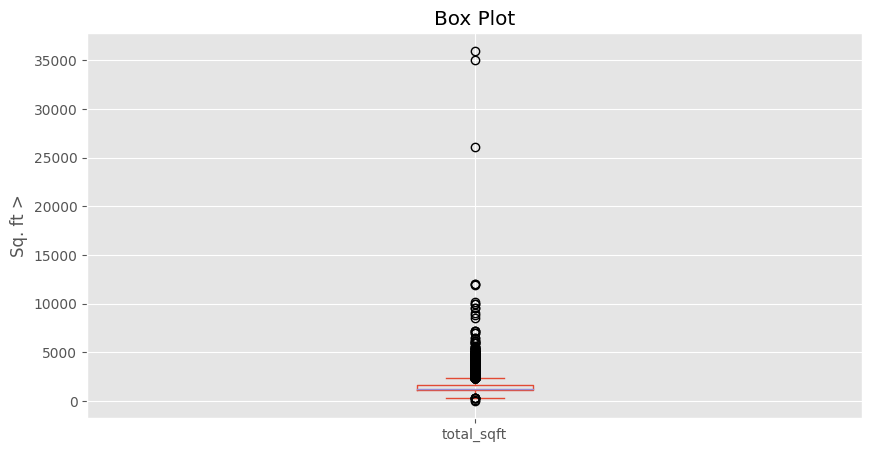

In [16]:
# Seeing how distributed the numbers are using a box plot:

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10,5]
    
ax = df['total_sqft'].plot(kind= 'box')

ax.set_title('Box Plot')
ax.set_ylabel('Sq. ft >')

plt.show()

As we can see the distribution is very uneven. We will use __Inter Quartile Range__ (__IQR__) to get rid of extremely small and large values or __outliers__.

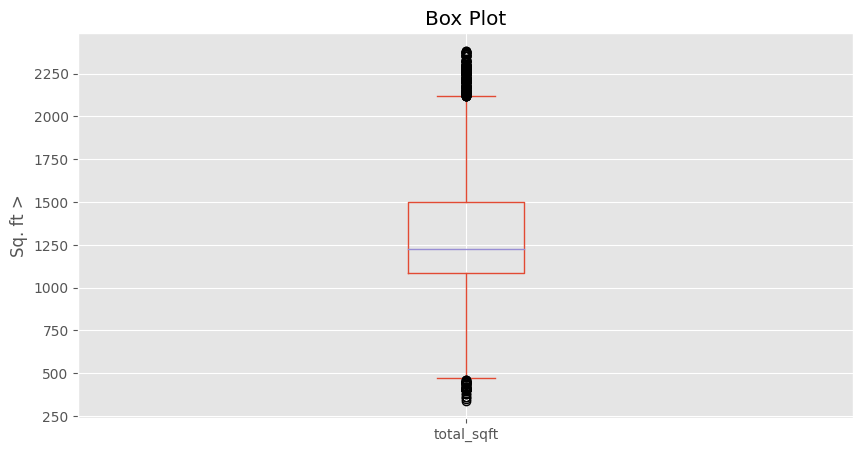

In [17]:
# Calculating Q1, Q2 and IQR:

Q1 = df['total_sqft'].quantile(0.25) #... Q1 is the first 25% of the data.
Q3 = df['total_sqft'].quantile(0.75) #... Q2 is the first 75% of the data.

Iqr = Q3 - Q1 #... IQR is the difference between the two Quartiles.

# Getting rid of the outliers:

df = df[ (df['total_sqft'] >= Q1 - 1.5 * Iqr) & 
         (df['total_sqft'] <= Q3 + 1.5 * Iqr) ] #... The formula is standard.

# Plotting the distribution again:

ax = df['total_sqft'].plot(kind= 'box')

ax.set_title('Box Plot')
ax.set_ylabel('Sq. ft >')

plt.show()

Something else that could also hinder our model is the __price per square foot__. An abnormal price for each square foot will influence the model's accuracy. So we will calculate it and see its distribution.

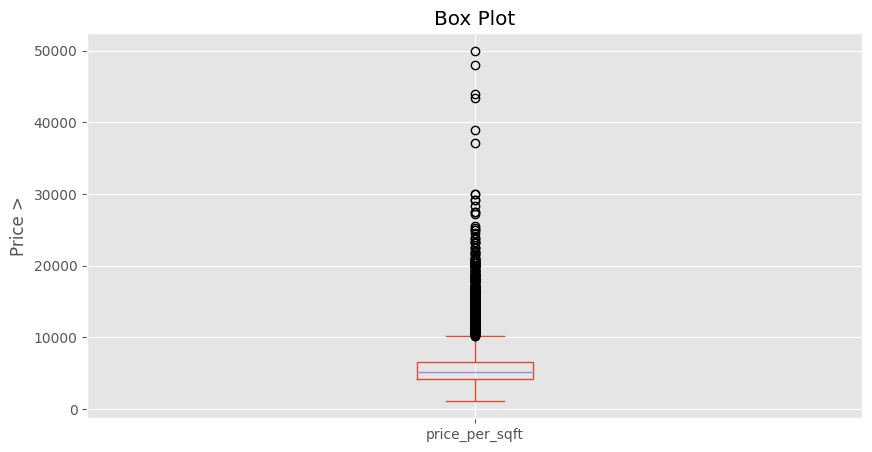

In [18]:
# Calculating price per square foot of each house:

df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

# Seeing the distribution of the column with a box plot:

ax = df['price_per_sqft'].plot(kind= 'box')

ax.set_title('Box Plot')
ax.set_ylabel('Price >')

plt.show()

So it's also quite uneven. Let's remove those outliers from the data using the __IQR__.

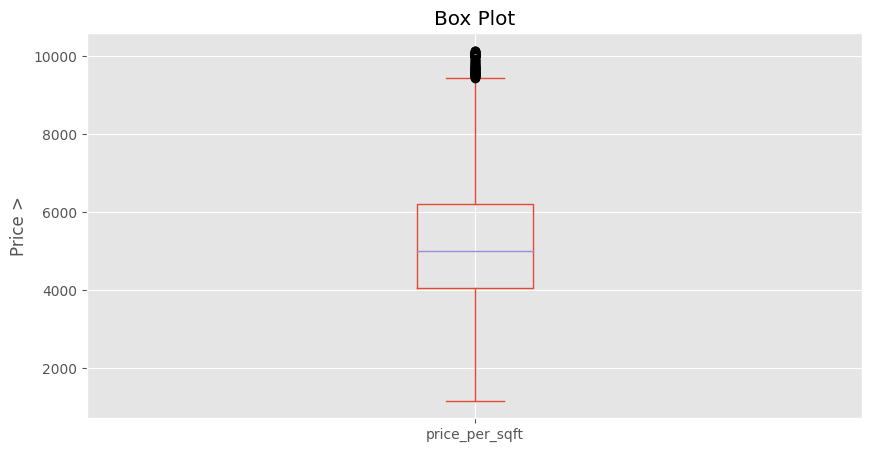

In [19]:
# Calculating Q1, Q2 and IQR:

q1 = df['price_per_sqft'].quantile(0.25)
q3 = df['price_per_sqft'].quantile(0.75)

iqr = q3 - q1

# Getting rid of the outliers:

df = df[ (df['price_per_sqft'] >= q1 - 1.5 * iqr) & 
         (df['price_per_sqft'] <= q3 + 1.5 * iqr) ] 

# Plotting the distribution again:

ax = df['price_per_sqft'].plot(kind= 'box')

ax.set_title('Box Plot')
ax.set_ylabel('Price >')

plt.show()

# Dropping the new column:

df = df.drop('price_per_sqft', axis= 'columns')

There's more, the average size of one bhk cannot be less than a certain size. 1 bhk cannot certainly be 100 sqft. After looking I found that a 1 bhk apartment is at least __400-450 sqft__. So we can use a formula that divides total sqft with bhk and anything under __400 sqft__ will be discarded as an outlier.

In [20]:
# Dividing 'total_sqft' by 'bhk' to get sqft per bhk:

sqft_per_bhk = df['total_sqft'] / df['bhk']

# Getting items that are less than 400 sqft:

items_less_than_400 = sqft_per_bhk < 400

# Removing them:

df = df[~items_less_than_400]

Now we are done with the cleaning. We will see how many observations are left to prepare our model. 

In [21]:
print(f'We have {df.shape[0]} rows & {df.shape[1]} columns left.')

We have 7333 rows & 7 columns left.


We will now start to build a model. First, we need to create dummy variables for __locations__ and __area types__ to make them compatible with our model.

In [22]:
# Creating dummy variables for locations & area types:

location_dummies = pd.get_dummies(df['location'])
area_type_dummies = pd.get_dummies(df['area_type'])

# Joining them with the original data frame:

df = pd.concat([df, location_dummies, area_type_dummies], axis= 'columns')

# Dropping the original columns:

df = df.drop(['location', 'area_type'], axis= 'columns')

# Printing the first 5 rows & 8 columns of the data frame:

print(f'The data frame has {df.shape[0]} rows & {df.shape[1]} columns.\n')

print('The first 5 rows & 9 columns of the data frame:\n')

df.iloc[:5, :9].reset_index(drop= True)

The data frame has 7333 rows & 193 columns.

The first 5 rows & 9 columns of the data frame:



,total_sqft,bath,balcony,price,bhk,1st Phase JP Nagar,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar
0,1056.0,2.0,1.0,39.07,2.0,False,False,False,False
1,1440.0,2.0,3.0,62.00,3.0,False,False,False,False
2,1521.0,3.0,1.0,95.00,3.0,False,False,False,False
3,1200.0,2.0,1.0,51.00,2.0,False,False,False,False
4,1170.0,2.0,1.0,38.00,2.0,False,False,False,False


Now we will create the x and y variable for our model. 

In [23]:
x = df.drop('price', axis= 'columns')

y = df['price'].values

It's time for hyperparameter tuning. We will use four machine learning models — __Suport Vector Regression__, __Lasso Regression__, __Decision Tree Regression__, and __Random Forest Regression__ — with different parameters and try to come out with the best model and parameters for this case.

In [24]:
# Creating a dictionary with all the models and the parameters:

dictionary = { 'model1': SVR(), 
               'params1': {'kernel': ['rbf','linear','sigmoid']},
         
               'model2': Lasso(), 
               'params2': {'alpha': [1,2,3],
                           'selection': ['random', 'cyclic']},
         
               'model3': DecisionTreeRegressor(), 
               'params3': {'criterion': ['squared_error', 'friedman_mse'], 
                           'splitter': ['best', 'random']},
         
               'model4': RandomForestRegressor(), 
               'params4': {'criterion': ['squared_error', 'friedman_mse']} } 

# Creating a function to get the best score and parameter of the models:

def score(model, params): 
    # Scalling the x variable:
    scaler = StandardScaler()
    X = scaler.fit_transform(x.values)
    # Using grid search cv:
    cv = ShuffleSplit(n_splits= 5, test_size= 0.25, random_state= 42)
    grid = GridSearchCV(estimator= model, param_grid= params, cv= cv)
    grid.fit(X,y)
    # Getting the best scores:
    best_score = round(grid.best_score_ * 100, 2)
    
    print(f'  Model: {model} \n' +
          f' Best Parameters: {grid.best_params_} \n' +
          f' Best Score: {best_score}% \n')
    

print('All 4 Models With The Best Parameters & Score: \n')

# Running the function with different models:

score(dictionary['model1'], dictionary['params1'])
score(dictionary['model2'], dictionary['params2'])
score(dictionary['model3'], dictionary['params3'])
score(dictionary['model4'], dictionary['params4'])

All 4 Models With The Best Parameters & Score: 

  Model: SVR() 
 Best Parameters: {'kernel': 'linear'} 
 Best Score: 73.77% 

  Model: Lasso() 
 Best Parameters: {'alpha': 1, 'selection': 'cyclic'} 
 Best Score: 68.51% 

  Model: DecisionTreeRegressor() 
 Best Parameters: {'criterion': 'squared_error', 'splitter': 'random'} 
 Best Score: 67.26% 

  Model: RandomForestRegressor() 
 Best Parameters: {'criterion': 'friedman_mse'} 
 Best Score: 76.58% 



So the __Random Forest Regression__ model has the highest score. We will use that as our preferred model to make predictions. We will also create a function that will help us to do predictions hassle-free.

In [25]:
# Scalling the x variable:
    
scaler = StandardScaler()

X = scaler.fit_transform(x.values)

# Fitting the model:

model = RandomForestRegressor(criterion= 'friedman_mse')
model.fit(X,y)

# Creating a function to make predictions easy:

def predict_price(location,area_type,sqft,bath,balcony,bhk):   
    # Finding the location and area type from the columns:
    loc_index = np.where(x.columns==location)[0][0]
    area_type_index = np.where(x.columns==area_type)[0][0]
    # Creating zeroes the same as the number of columns in the data frame:
    X = np.zeros(len(x.columns)) 
    # Replacing the first four zeroes with the other input variables:
    X[0] = sqft
    X[1] = bath
    X[2] = balcony
    X[3] = bhk    
    # Finding the location and the area type and replacing it with 1:
    if loc_index >= 0:
        X[loc_index] = 1
    if area_type_index >= 0:
        X[area_type_index] = 1
        
    # Returning the prediction result:
    return model.predict([X])[0]

Now we will just make predictions for three random houses using the __location__, the __area type__, total __square foot__ of the house,no. of __balconies__ available, no. of __bathrooms__,  and total __Bhk__.

The price of the following three houses will be predicted by the model:

    1) Location = Whitefield
       Area Type = Super Built-up Area
       Sqft = 2753
       Balcony = 1
       Bath = 4
       Bhk = 3
           
    2) Location = 8th Phase JP Nagar
       Area Type = Built-up Area
       Sqft = 3500
       Balcony = 2
       Bath = 2
       Bhk = 3
           
    3) Location = Sarjapur  Road
       Area Type = Super Built-up Area
       Sqft = 1507
       Bath = 3
       Balcony = 2
       Bhk = 3  

In [26]:
# Creating variables for each prediction result:

result_1 = predict_price('Whitefield', 'Super built-up  Area',
                          2753, 4, 1, 3)
result_2 = predict_price('8th Phase JP Nagar', 'Built-up  Area',
                          3500, 2, 2, 3)
result_3 = predict_price('Sarjapur  Road', 'Super built-up  Area',
                          1507, 3, 2, 3)

# Predicting the prices:

print('Prediction Results:')

print(f' Price of 1st house is Rs. {round(result_1 * 100000, 2)} \n' + 
      f' Price of 2nd house is Rs. {round(result_2 * 100000, 2)} \n' +
      f' Price of 3rd house is Rs. {round(result_3 * 100000, 2)} \n')

Prediction Results:
 Price of 1st house is Rs. 17364730.0 
 Price of 2nd house is Rs. 17418466.67 
 Price of 3rd house is Rs. 17128960.0 



__Note__: The price may vary each time the model is run.

__~ Created by Sourin Das__